## Assignment 4

# Determining and removing drawbacks of exponential and running mean

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of Assignment 4 is to detemine conditions for which broadly used methods of running and exponential mean provide effective solution and conditions under which they break down. Important outcome of this assignment is getting skill to choose the most effective method in conditions of uncertainty.**

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

### Part I - Comparision of the traditional 13-month running mean with the forward-backward exponential smoothing for approximation of 11-year sunspot cycle.

**Firstly, we make smoothing of monthly mean data using 13-month running mean.**

In [2]:
# Read data separated by whitespace from a text file (column labels are not specified in the file)

df = pd.read_csv('data_group1.txt', header=None, delim_whitespace=True)

In [3]:
# Set column names to data frame

df.columns = ['Year', 'Month', 'Monthly sunspot number']

In [4]:
# Define a function which returns array smoothed using 13-month running mean

def runMean(arr):
    cur_arr = arr.copy()
    for i in range(6, len(arr)-6):
        cur_arr[i] = arr[(i-5):(i+6)].sum() / 12 + (arr[i-6]+arr[i+6]) / 24
    return cur_arr 

In [5]:
# The first and the last six months of data are averaged in order to get smoothed estimates

sunNum = np.array(df['Monthly sunspot number'])
smoothSunNum = sunNum.copy()
smoothSunNum[0:6] = sunNum[0:6].mean()
smoothSunNum[-6:] = sunNum[-6:].mean()

In [6]:
# Calculate 13-month running mean in order to make smoothed monthly mean data

smoothSunNum_run = runMean(smoothSunNum)

**Secondly, we make smoothing of monthly mean data using forward-backward exponential smoothing**

Forward exponential smoothing is defined as follows: $X_i^f = X_{i-1}^f + \alpha(z_i - X_{i-1}^f),   i = 2, ..., N$, where $X_i^f$ - estimates of forward exponential smoothing, $z_i$ - measurements.

In [7]:
# Define a function which returns an array smoothed by forward exponential smoothing

def exp_smooth(Z, α=0.355):
    arr = Z.copy()
    for i in range(1, len(Z)):
        arr[i] =  α * arr[i] + arr[i-1] * (1 - α)
    return arr

Backward exponential smoothing is defined as follows: $X_i^b = X_{i+1}^b + \alpha(X_i^f - X_{i+1}^b),   i = N-1, ..., 1$, where $X_i^b$ - estimates of backward exponential smoothing, $X_i^f$ - forward estimates.

In [8]:
# Define a function which returns an array smoothed by backward exponential smoothing 

def backward(e, α=0.355):
    arr = e.copy()
    for i in range(len(arr)-2, -1, -1):
        arr[i] = α * e[i] + (1 - α) * arr[i+1] 
    return arr

In [9]:
# Make forward-backward exponential smoothing of monthly mean sunspot number

smoothSunNum_exp = backward(exp_smooth(sunNum, 0.25), 0.25)

In [10]:
# Create an array of dates for x-axis

df['Date'] = df.Year.astype(str).str.cat(df.Month.astype(str), sep='/')
x = [dt.datetime.strptime(d,'%Y/%m').date() for d in df['Date']]

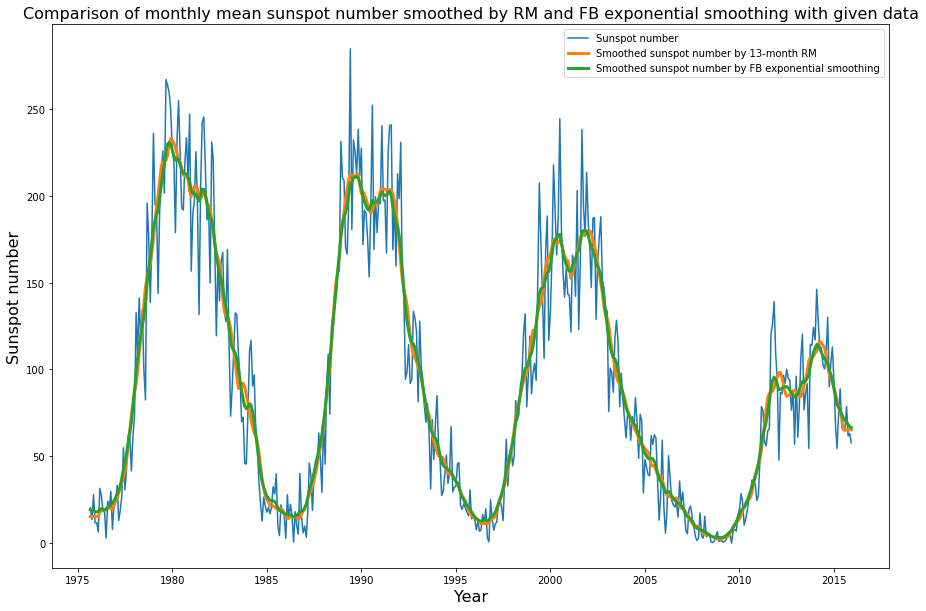

In [11]:
# Plot monthly mean sunspot number, data smoothed by 13-month running mean and by forward-backward exponential smoothing

plt.figure(figsize=(15,10))
plt.plot(x, sunNum)
plt.plot(x, smoothSunNum_run, linewidth=3)
plt.plot(x, smoothSunNum_exp, linewidth=3)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Sunspot number', fontsize = 16)
plt.legend(['Sunspot number', 'Smoothed sunspot number by 13-month RM', 'Smoothed sunspot number by FB exponential smoothing'])
plt.title('Comparison of monthly mean sunspot number smoothed by RM and FB exponential smoothing with given data', fontsize = 16);

**It is clearly seen from the graph that, although both smoothing methods provide us with quite similiar results, forward-backward exponential smoothing gives more accurate location of peaks and troughs without any shifts which appear for 13-month running mean smoothing method. In order to verify the effectiveness of smoothing when true trajectory is unknown, deviation and variability indicators should be calculated.**

In [12]:
# Define a function which returns deviation indicator

def deviation(Z, smooth):
    return sum((Z - smooth) ** 2)

In [13]:
# Define a function which returns variability indicator

def variability(smooth):
    return sum((smooth[2:] - 2 * smooth[1:-1] + smooth[:-2]) ** 2)

In [14]:
print('Deviation indicator for 13-month running mean smoothing is %.0f' % deviation(sunNum, smoothSunNum_run) + '.')
print('Deviation indicator for forward-backward exponential smoothing is %.0f' % deviation(sunNum, smoothSunNum_exp) + '.')

Deviation indicator for 13-month running mean smoothing is 212420.
Deviation indicator for forward-backward exponential smoothing is 176678.


In [15]:
print('Variability indicator for 13-month running mean smoothing is %.0f' % variability(smoothSunNum_run) + '.')
print('Variability indicator for forward-backward exponential smoothing is %.0f' % variability(smoothSunNum_exp) + '.')

Variability indicator for 13-month running mean smoothing is 1801.
Variability indicator for forward-backward exponential smoothing is 1226.


**Smoothing constant $\alpha$=0.25 provides better results according to deviation and variability indicators. Thus, forward-backward exponential smoothing is more effective than 13-month running mean smoothing in this particular case.**

### Part II - 3D surface filtration using forward-backward smoothing.

In [16]:
# Import noisy measurements to work with and true surface to compare the estimation results

noisy = pd.read_csv('noisy_surface.txt', header=None, delim_whitespace=True)
true = pd.read_csv('true_surface.txt', header=None, delim_whitespace=True)

In [17]:
# Initialisation of 2D coordinate system: 

x = np.arange(0, 51, 1)
y = np.arange(0, 51, 1)
X, Y = np.meshgrid(x, y)

In [18]:
# Copy arrays

Z_n = np.array(noisy)
Z_t = np.array(true)

In [19]:
# Import libraries for plotting 3D graphs

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

**First of all, we visualise noisy surface to understand what we are working on.**

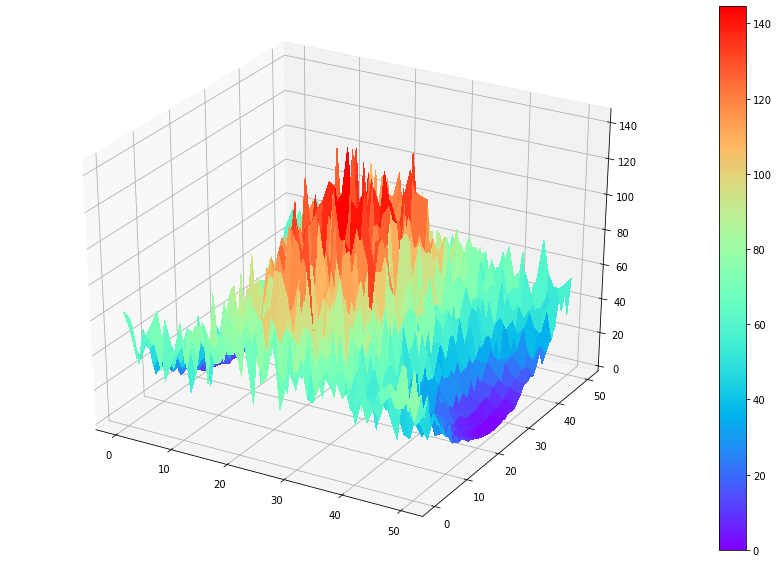

In [22]:
# Plot noisy surface

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow)
mappable.set_array(Z_n)
plt.colorbar(mappable);

surf = ax.plot_surface(X, Y, Z_n, cmap=plt.cm.rainbow, linewidth=0, antialiased=False);

In [23]:
# Calculate the variance of deviation of noisy surface from the true one

dif = (Z_n - Z_t).reshape((1,-1))
print('Variance of deviation equals to %.1f' % np.var(dif) + '.')

Variance of deviation equals to 120.6.


In [24]:
# Apply forward-backward exponential smoothing to filter noisy measurements according to hints given in the assignment

smooth = noisy.copy()

smooth = np.apply_along_axis(exp_smooth, 1, smooth)
smooth = np.apply_along_axis(backward, 1, smooth)

smooth = np.apply_along_axis(exp_smooth, 0, smooth)
smooth = np.apply_along_axis(backward, 0, smooth)

**Now, after applying forward-backward exponential smoothing on noisy surface, we plot both true and smoothed surfaces for visual comparison.**

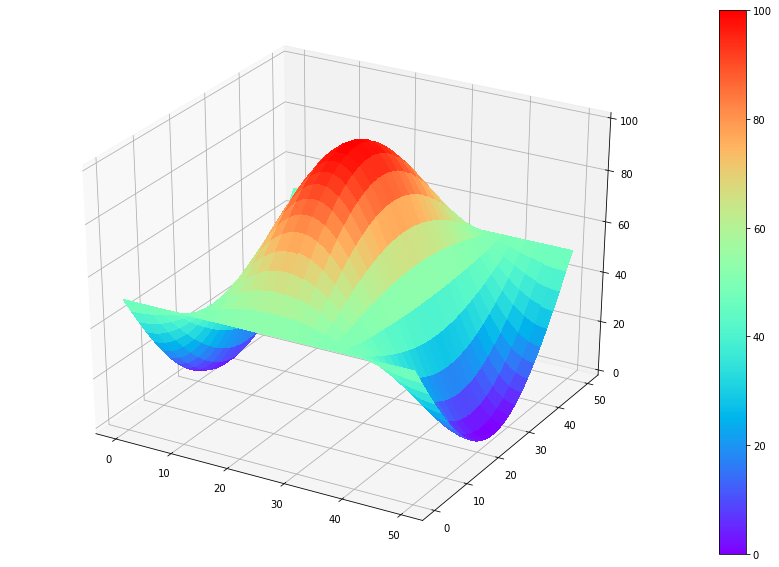

In [25]:
# Plot true surface

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow)
mappable.set_array(Z_t)
plt.colorbar(mappable)

surf = ax.plot_surface(X, Y, Z_t, cmap=plt.cm.rainbow, linewidth=0, antialiased=False)

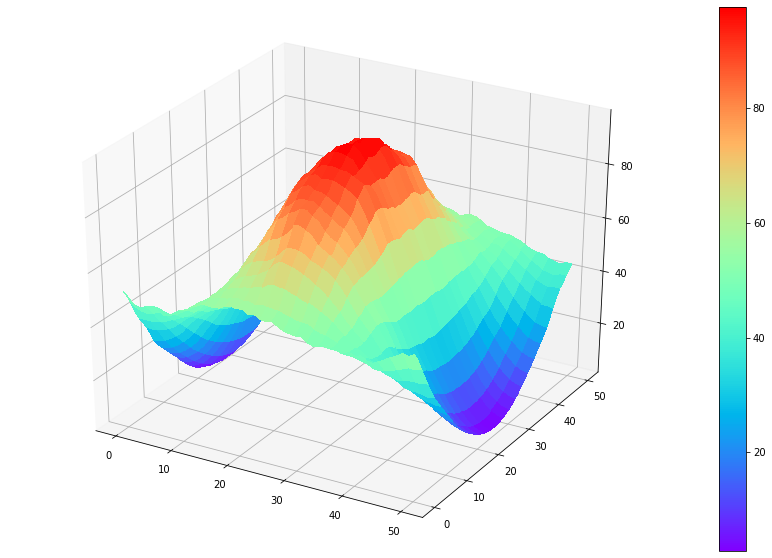

In [26]:
# Plot smoothed surface

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow)
mappable.set_array(smooth)
plt.colorbar(mappable)

surf = ax.plot_surface(X, Y, smooth, cmap=plt.cm.rainbow, linewidth=0, antialiased=False);

**Reconstructed surface looks highly similiar to the true surface. However, in order to verify numerically the effectiveness of smoothing, the variance of deviation of noisy surface from the true one should be calculated.**

In [27]:
# Calculate the variance of deviation of noisy surface from the true one

dif = (smooth - Z_t).reshape((1,-1))
print('Variance of deviation equals to %.1f' % np.var(dif) + '.')

Variance of deviation equals to 5.8.


**In comparison to the variance of deviation which was calculated for noisy and true surface, the latter result is much smaller. It proves that forward-backward exponential smoothing method effectively filtrated noisy 3D surface.**

**The more the value of $\alpha$, the more the number of peaks on the plot, so that the surface becomes "rougher". Otherwise, the surface becomes flatter.**

**Conclusion: Since it was our fourth assignment, it became easier for those of us, who had experience only with MatLab, to code on Python as we have already learnt and practiced a lot the basics of this programming language. Nevertheless, there were some new features which we learnt this time. First of all, we realised that we should use dates on the x-axis as a combination of a month and a year when plotting monthly sunspot number vs date: we haven't done it during the first assignment and got a less "eye-friendly" graph (UPD: and a low mark), but now we know how to do better. Moreover, we found out how to plot 3D graphs and how to use colorbars in order to get a better visualisation of data which is always a useful skill for data processing. It was not a problem at all to conduct 13-month running mean smoothing as we did it many times before, however the process of forward-backward exponential smoothing was more complicated and some of us made mistakes which were detected only through a critical assessment of the reconstructed surface: we were wondering why the surface had some strange convexities which were not supposed to appear. These convexities could lead us to a wrong result. In this case, we saw that, although the smoothing lines of both methods under study were quite similiar, 13-month running mean smoothing gave a shift in the peaks which resulted in data distortion. Moreover, we became confident one more time that it is extremely important to choose the optimal smoothing constant alpha in order to avoid graph distortions when applying exponential smoothing. In addition to visual assessments of the correctness of smoothing, variability and deviation indicators became our "helpers" again in understanding which smoothing method is better.**